In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import h5py, os, tqdm
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.49'
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

import jax
import jax.numpy as jnp
import jax_cosmo as jc

from flax import nnx
import orbax.checkpoint as ocp

import jaxpm
from jaxpm.painting import cic_paint, cic_read
from jaxpm.kernels import fftk, invnabla_kernel
from jaxpm.nn import MLP
from jaxpm import camels, plotting, hpm, nn

jax.devices("gpu")

[cuda(id=0)]

In [7]:
parts_per_dim = 64
mesh_per_dim = parts_per_dim
mesh_shape = [mesh_per_dim] * 3
box_size = [float(mesh_per_dim)] * 3

In [8]:
# SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_0"
# SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_1"
SIM = "/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2"

out_dict = camels.load_CV_snapshots(
    SIM,
    mesh_per_dim,
    parts_per_dim,
    i_snapshots=range(1, 33+4, 4),
    return_hydro=True,
)

cosmo = out_dict["cosmo"]
scales = out_dict["scales"]

dm_poss = out_dict["dm_poss"]
dm_vels = out_dict["dm_vels"]

gas_poss = out_dict["gas_poss"]
gas_vels = out_dict["gas_vels"]

Using snapshots ['/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_018.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_034.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_042.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_050.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_058.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_066.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_074.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_082.hdf5', '/cluster/work/refregier/athomsen/flatiron/CAMELS/Sims/IllustrisTNG/CV/CV_2/snapshot_090.hdf5']
Selecting 262144 dark matter (deterministic)
Selecting 262144 gas particles (random)


loading snapshots: 100%|██████████| 9/9 [01:07<00:00,  7.55s/it]


In [9]:
vcic_paint = jax.vmap(cic_paint, in_axes=(None,0,None))
vcic_read = jax.vmap(cic_read, in_axes=(0,0))

rho_dm = vcic_paint(jnp.zeros(mesh_shape), dm_poss, 1)
rho_gas = vcic_paint(jnp.zeros(mesh_shape), gas_poss, cosmo.Omega_b / cosmo.Omega_c)
rho_tot = rho_dm + rho_gas

gas_rho_tot = vcic_read(rho_tot, gas_poss)

kvec = fftk(mesh_shape)
rho_k_tot = jax.vmap(jnp.fft.rfftn, in_axes=0)(rho_tot)
gas_fscalar = vcic_read(
    jax.vmap(jnp.fft.irfftn, in_axes=0)(rho_k_tot * invnabla_kernel(kvec)), 
    gas_poss
)


gas_inputs = jnp.stack(
    [
        jnp.repeat(scales[:,jnp.newaxis], parts_per_dim**3, axis=1), 
        jnp.log10(gas_rho_tot), 
        jnp.arcsinh(gas_fscalar / 100)
    ],
    axis=-1,
)

# table

In [10]:
model = MLP(3, 2, 64, 4, nnx.Rngs(0))

# checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp_v5.jx")
checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_mlp_cv1_v1.jx")
checkpointer = ocp.StandardCheckpointer()

abstract_model = nnx.eval_shape(lambda: model)
graphdef, abstract_params = nnx.split(abstract_model)

params = checkpointer.restore(checkpoint_file, abstract_params)
mlp_table = nnx.merge(graphdef, params)

/cluster/home/athomsen/flatiron/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# fit to sim

### particle-level

In [11]:
model = MLP(3, 1, 64, 4, nnx.Rngs(0))

checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_sim_v1.jx")
checkpointer = ocp.StandardCheckpointer()

abstract_model = nnx.eval_shape(lambda: model)
graphdef, abstract_params = nnx.split(abstract_model)

params = checkpointer.restore(checkpoint_file, abstract_params)
mlp_sim = nnx.merge(graphdef, params)

### pixel-level

In [134]:
model = MLP(3, 1, 64, 4, nnx.Rngs(0))

checkpoint_file = os.path.join(os.getcwd(), "checkpoints/hpm_sim_field_cv0.jx")
checkpointer = ocp.StandardCheckpointer()

abstract_model = nnx.eval_shape(lambda: model)
graphdef, abstract_params = nnx.split(abstract_model)

params = checkpointer.restore(checkpoint_file, abstract_params)
mlp_sim_pix = nnx.merge(graphdef, params)

/cluster/home/athomsen/flatiron/lib/python3.11/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1386: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


# eval 

### table vs. sim

In [12]:
out_table = mlp_table(gas_inputs)[...,0]
out_sim = jnp.squeeze(mlp_sim(gas_inputs))

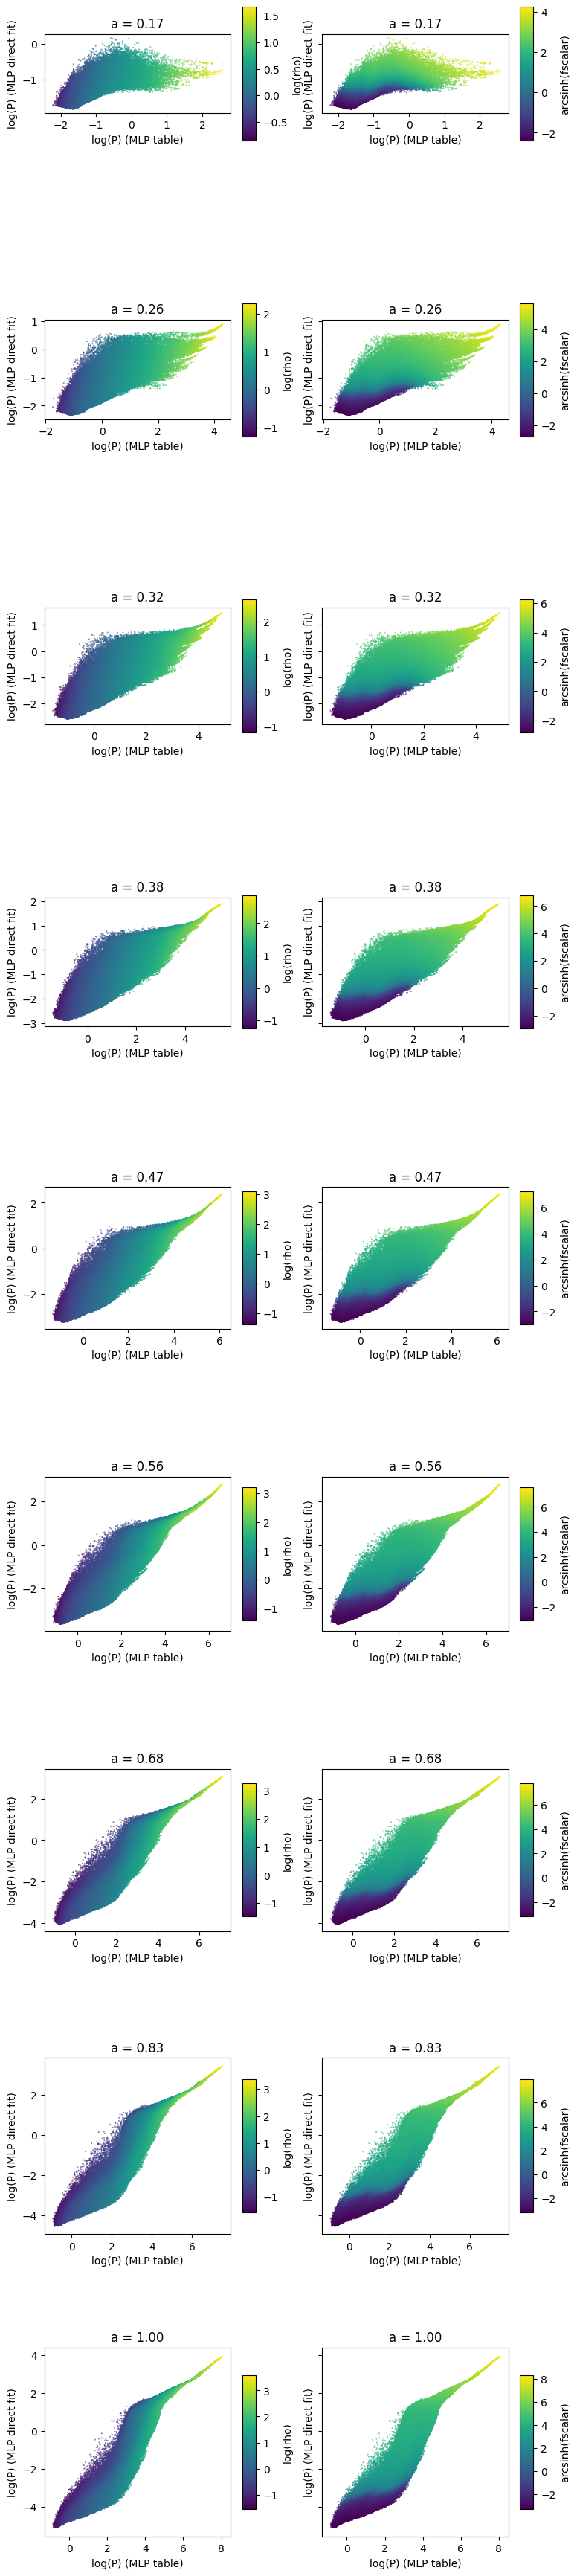

In [13]:
nrows = len(scales)

fig, ax = plt.subplots(figsize=(2*4,nrows*4), nrows=nrows, ncols=2, sharex="row", sharey="row")

for i, scale in enumerate(scales):    
    im = ax[i,0].scatter(out_table[i], out_sim[i], s=0.1, c=np.log10(gas_rho_tot[i]))
    fig.colorbar(im, ax=ax[i,0], orientation="vertical", shrink=0.5, aspect=10, label="log(rho)")
                 
    im = ax[i,1].scatter(out_table[i], out_sim[i], s=0.1, c=np.arcsinh(gas_fscalar[i]))
    fig.colorbar(im, ax=ax[i,1], orientation="vertical", shrink=0.5, aspect=10, label="arcsinh(fscalar)")
    
    for j in range(2):
        ax[i,j].set(xlabel="log(P) (MLP table)", ylabel="log(P) (MLP direct fit)", title=f"a = {scale:.2f}")
        ax[i,j].set_aspect("equal")

fig.tight_layout()

### particle- vs. pixel-level loss

In [135]:
out_sim_part = jnp.squeeze(mlp_sim(gas_inputs))
out_sim_pix = jnp.squeeze(mlp_sim_pix(gas_inputs))

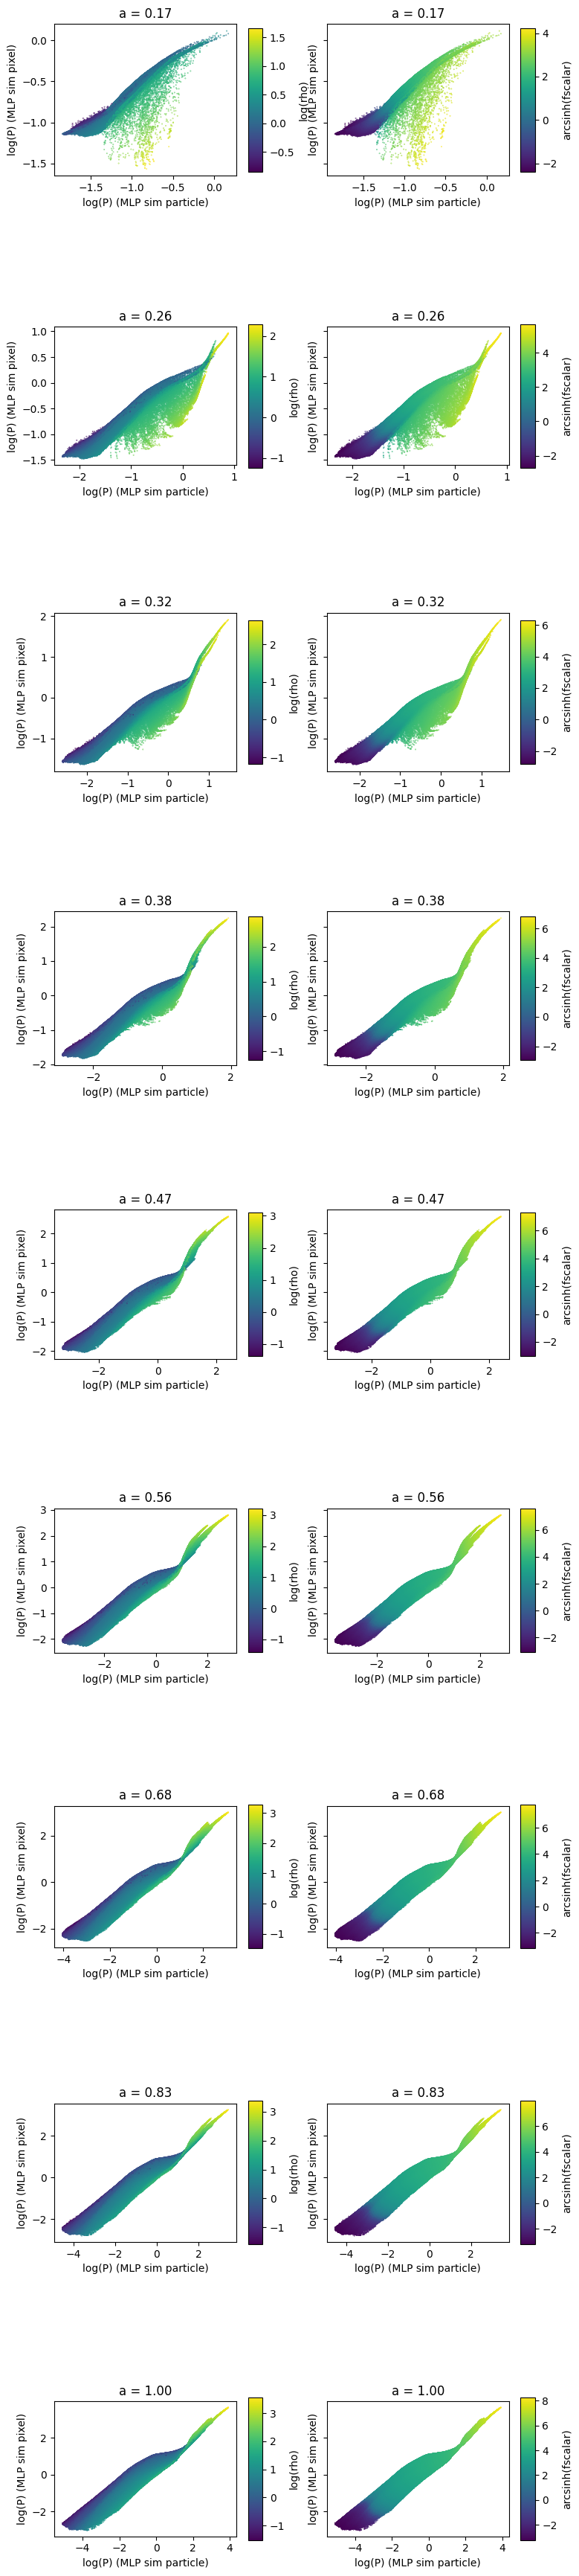

In [136]:
nrows = len(scales)

fig, ax = plt.subplots(figsize=(2*4,nrows*4), nrows=nrows, ncols=2, sharex="row", sharey="row")

for i, scale in enumerate(scales):    
    im = ax[i,0].scatter(out_sim_part[i], out_sim_pix[i], s=0.1, c=np.log10(gas_rho_tot[i]))
    fig.colorbar(im, ax=ax[i,0], orientation="vertical", shrink=0.5, aspect=10, label="log(rho)")
                 
    im = ax[i,1].scatter(out_sim_part[i], out_sim_pix[i], s=0.1, c=np.arcsinh(gas_fscalar[i]))
    fig.colorbar(im, ax=ax[i,1], orientation="vertical", shrink=0.5, aspect=10, label="arcsinh(fscalar)")
    
    for j in range(2):
        ax[i,j].set(xlabel="log(P) (MLP sim particle)", ylabel="log(P) (MLP sim pixel)", title=f"a = {scale:.2f}")
        ax[i,j].set_aspect("equal")

fig.tight_layout()